In [1]:
# 単回帰分析
# 敷地面積と価格を単回帰分析を行い、敷地面積から価格を予測する（回帰直線を求める）
# 最小2乗法を使った標準的な単回帰分析と異なり、ベイズによってある程度のデータの揺らぎ（正規分布に従う）を許容する

# 仮説
# (1) 物件価格はax+bで表せる。x: 敷地面積, a:もとめる傾き, b:もとめる切片
# (2) yは正規分布に従う。
#    つまり、ある敷地面積xに対して、価格yは平均値=ax+b, 標準偏差σの正規分布にしたがってばらつきがあると仮定している

# 統計モデル
# y[n] ~ Normal(ax[n]+b, σ)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
# データ読込み
df = pd.read_csv("./data/real_estate1.csv")

In [4]:
# データの確認
df.head()

# id:物件のID, space:敷地面積, room:部屋タイプ, value:価格[万円]

,id,space,room,value
0,1,50,2LDK,3050
1,2,70,2LDK,4690
2,3,70,2SLDK,4830
3,4,70,3LDK,5040
4,5,90,3LDK,6570


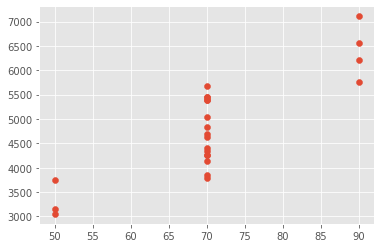

In [5]:
# x軸を敷地面積、y軸を価格でプロット
plt.scatter(df["space"], df["value"])

# 実行してみると、各敷地面積ごとの価格プロットの集まりが、おおよそ右肩上がりになっている　→ 正の相関が強い
# そのため、y = ax + bの単回帰で表すことができそう（y:価格、x:敷地面積） ⇒ 単回帰分析をやってみよう、となる
# そして、各敷地面積ごとのデータの集まりが、正規分布に従って分布しているかも　→ yの分布は正規分布に従うと仮説を立てる
# 統計モデル: y[n] ~ Normal(a・x[n] + b, σ)とする

In [6]:
# PyStanのモデルを設定（PyStanの都合上、C++で記述）
stan_model = """
data {
  int N; // データの個数を設定
  real X[N]; // 単回帰の説明変数。ここでは敷地面積を設定
  real Y[N]; // 単回帰の目的変数。
}

// ここでのパラメータ設定は、回帰直線のパラメータを意味する
parameters {
  real a; // 傾き
  real b; // 切片
  real<lower=0> sigma; // 誤差σ。標準偏差なのでlower=0で、0以上であること明記
}

// Pystanモデルを設定
model {
  // n番目の事後分布が、正規分布に従う単回帰モデルであることを仮定する
  for (n in 1:N) {
    Y[n] ~ normal(a * X[n] + b, sigma);
  }
}
"""

In [7]:
# PyStanモデルをビルド
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3507a87fc69b734d2616594182f241f0 NOW.


In [8]:
# 渡すデータをセット
stan_data = {"N":df.shape[0], "X":df["space"], "Y":df["value"]}

In [9]:
# MCMCで事後分布をサンプリングする
# 以下はMCMCのパラメータ
#  iter: モンテカルロステップ回数（試行回数）
#  warmup: ウォームアップ期間（値が収束したとするまでの期間）
#  chains: モンテカルロステップ回数の繰り返し数
#  seed: 乱数の種
fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [10]:
fit

# 下記表はMCMCで求めた事後分布の結果
# 重要な列は、mean, se_mean, Rhat
#   mean: 事後分布の平均値。つまり、y=ax+bの傾きについては、おおよそ79.3になることが表からわかる
#   se_mean: 事後分布の標準誤差。こいつが大きいとあまり信用できない結果であることがわかる
#   Rhat: MCMCによる計算が収束しているか。1に近ければ収束していることになる

Inference for Stan model: anon_model_3507a87fc69b734d2616594182f241f0.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      79.03    0.34  11.64  55.52  71.61  78.88  86.74  102.2   1175    1.0
b     -764.1   24.21 834.46  -2433  -1315 -764.7 -230.8 907.49   1188    1.0
sigma 614.85    2.95 106.34  447.4 540.73 601.81 673.65 855.25   1303    1.0
lp__  -152.0    0.04   1.35 -155.3 -152.6 -151.6 -151.0 -150.5   1096    1.0

Samples were drawn using NUTS at Mon Sep 21 20:17:35 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

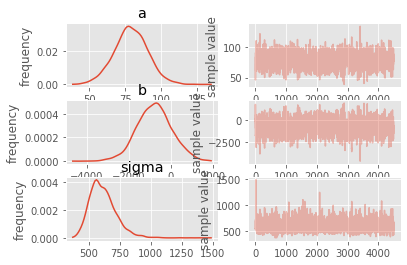

In [11]:
# 結果をグラフ化する
fig = fit.plot()

# 右図をみると、値が振動しており、MCMCで満遍なくサンプリングしてきていることがわかる
# MCMCはあくまで確率的に動作するため、振動していないと、うまくMCMCでサンプリングできていないことを意味する

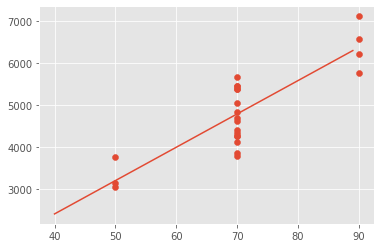

In [12]:
# 事後分布の平均値a, bを使って回帰直線を引く
a = 79.3
b = -764.1
x = np.arange(40, 90, 1)  # 40m^2 - 90m^2の範囲でグラフ化
y = a * x + b
plt.plot(x, y)  # 直線を引く
plt.scatter(df["space"], df["value"])  # データを点で表示